**In The Name Of God**
<html>
<div>
  <span style="font-family: Poppins; font-size:30px; color: pink;"> University of Tehran <br/> Deep Learning <br/> Convolutional Neural Networks <br/> CA5
</div>
<span style="font-family: Poppins; font-size:15pt; color: pink; vertical-align: middle;"> <br> Mobina Haghizadeh </span><br>
<span style="font-family: Poppins; font-size:15pt; color: pink; vertical-align: middle;"> 810100127 </span>

</html>

# Description
I have a dataset of tweets, and my task is to analyze the data using CNNs and NLP to recognize suicidal tweets as opposed to non-suicidal ones.

# Setup environment

In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.2 MB/s eta 0:00:00


# Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from tqdm import tqdm
import gc
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer , WordNetLemmatizer
from nltk.corpus import stopwords
import difflib

from gensim import downloader as api
from torch.utils.data import Dataset


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Mounted at /content/drive


# Config

## Model training config

In [3]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants

In [5]:
data_csv_path = '/content/drive/MyDrive/twitter-suicidal-data.csv'

# Part Zero:
# Data Preparation
I have to write a function that takes a tweet as input, processes the text of the tweet, and then returns the token list.

In [6]:
nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

class Tweet:
    def __init__(self, text):
        self.text = text

    def remove_punctuation(self):
        self.text = self.text.translate(str.maketrans('', '', string.punctuation))

    def remove_numbers(self):
        self.text = re.sub(r'\d+', '', self.text)

    def remove_links(self):
        pattern = r'https?://\S+|www\.\S+'
        self.text = re.sub(pattern, '', self.text)

    def remove_user_references(self):
        pattern = r'@\w+'
        self.text = re.sub(pattern, '', self.text)

    def remove_emojis(self):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        self.text = emoji_pattern.sub(r'', self.text)

    def standardize_spaces(self):
        self.text = re.sub(r'\s+', ' ', self.text).strip()

    def remove_non_word_phrases(self):
        self.text = ' '.join(re.findall(r'\b\w+\b', self.text))

    def stemming_tokens(self):
        tokens = word_tokenize(self.text)
        stemmer = PorterStemmer()
        self.text = ' '.join([stemmer.stem(token) for token in tokens])

    def lemmatize_tokens(self):
        tokens = word_tokenize(self.text)
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        self.text = ' '.join(lemmatized_tokens)

    def remove_stopwords(self):
        tokens = word_tokenize(self.text)
        stop_words = set(stopwords.words('english'))
        self.text = ' '.join([token for token in tokens if token.lower() not in stop_words])

    def preprocess_tweet(self):
        self.text = self.text.lower()
        self.remove_punctuation()
        self.remove_numbers()
        self.remove_links()
        self.remove_user_references()
        self.remove_emojis()
        self.standardize_spaces()
        self.remove_non_word_phrases()
        self.lemmatize_tokens()
        self.remove_stopwords()
        return self.text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [7]:
# nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

def remove_links(text):
    pattern = r'https?://\S+|www\.\S+'
    text = re.sub(pattern, '', text)
    return text

def remove_user_references(text):
    pattern = r'@\w+'
    text = re.sub(pattern, '', text)
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002500-\U00002BEF"  # chinese char
                                u"\U00002702-\U000027B0"
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                u"\U0001f926-\U0001f937"
                                u"\U00010000-\U0010ffff"
                                u"\u2640-\u2642"
                                u"\u2600-\u2B55"
                                u"\u200d"
                                u"\u23cf"
                                u"\u23e9"
                                u"\u231a"
                                u"\ufe0f"  # dingbats
                                u"\u3030"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

def standardize_spaces(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_non_word_phrases(text):
    text = ' '.join(re.findall(r'\b\w+\b', text))
    return text

def stemming_tokens(text):
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(token) for token in tokens])
    return text

def lemmatize_tokens(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    return text

def remove_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([token for token in tokens if token.lower() not in stop_words])
    return text

def preprocess_tweet(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_links(text)
    text = remove_user_references(text)
    text = remove_emojis(text)
    text = standardize_spaces(text)
    text = remove_non_word_phrases(text)
    text = lemmatize_tokens(text)
    text = remove_stopwords(text)
    return text



In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stopwords = set(nltk.corpus.stopwords.words("english"))
lemmatizer = nltk.stem.WordNetLemmatizer()

def convert_emoji_to_text(text):
    """This function would replace emojis with a space"""
    return re.sub(r':[a-zA-Z_]+:', ' ', text)

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'@[^\s]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = convert_emoji_to_text(text)
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    nltk_tags = nltk.pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(token, pos=nltk_pos_tagger(tag)) for token, tag in nltk_tags]
    tokens = [token for token in tokens if token not in stopwords]
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Question1:
Converting text to lowercase in NLP projects offers advantages such as standardization, reducing vocabulary size, and improving model performance by treating similar words as identical. However, it may obscure proper nouns and lose some semantic information. We perform this preprocessing at the end to ensure consistency and avoid potential conflicts with other preprocessing steps.

Here are some additional disadvantages of converting text to lowercase in NLP projects:

- ``Loss of proper noun information:`` Lowercasing text can obscure proper nouns, such as names of people, places, or organizations. This loss of case information might be crucial in tasks like named entity recognition or sentiment analysis where recognizing entities accurately is essential.

- ``Loss of emphasis:`` Capitalization can sometimes convey emphasis or importance in text. Lowercasing removes this emphasis, potentially impacting the interpretation of the text, especially in tasks like sentiment analysis or opinion mining.

- ``Ambiguity in acronyms:`` Lowercasing can lead to ambiguity in acronyms or initialisms that are commonly written in uppercase. For example, "USA" could be mistaken for the word "usa" in lowercase.

- ``Impact on readability:`` In some cases, lowercasing can reduce the readability of text, especially if the original text contains a mix of uppercase and lowercase letters for emphasis or clarity.

- ``Loss of context:`` Lowercasing can potentially result in loss of context, especially in languages where case distinctions carry semantic meaning, such as German or Turkish. This loss of context might affect the accuracy of downstream NLP tasks.

And some other advantages are:

- ``Standardization:`` Lowercasing text ensures that words are represented consistently, regardless of their original capitalization. This standardization simplifies text processing and analysis, making it easier to compare and manipulate text data.

- ``Reduced vocabulary size:`` Lowercasing reduces the number of unique words in the vocabulary by collapsing words with different capitalizations into a single token. This reduction in vocabulary size can lead to faster processing and reduced computational resources required for training and inference.

- ``Improved model performance:`` Lowercasing can improve model performance by treating words with similar meanings but different capitalizations as identical. This allows the model to generalize better across different capitalization styles and improves its ability to recognize patterns in text data.

- ``Better tokenization:`` Lowercasing facilitates tokenization by reducing the complexity of text data. Tokenizers can split text into words more effectively when all words are in lowercase, leading to more accurate tokenization results.

- ``Case-insensitive matching:`` Lowercasing enables case-insensitive matching, making it easier to search and match text patterns without considering case distinctions. This is particularly useful in tasks like information retrieval, where case sensitivity may not be relevant.



## Question 2:
Advantages:

- ``Reduced Dimensionality:`` Removing numbers reduces the complexity of the text data by eliminating numerical values, leading to a simpler and more manageable dataset.

- ``Improved Model Generalization:`` By removing numbers, models may generalize better to new data since numerical values are often specific to the dataset and may not generalize well.

- ``Enhanced Text Clarity:`` Text without numbers may be easier to read and interpret, especially in tasks like sentiment analysis or topic modeling where numerical values may not contribute to the analysis.


Disadvantages:

- ``Loss of Information:`` Removing numbers may result in the loss of valuable information, especially in tasks where numerical data is relevant, such as sentiment analysis of product reviews containing ratings or NLP tasks involving numerical quantities.

- ``Contextual Misinterpretation:`` In some cases, removing numbers may lead to misinterpretation of text if numerical values are integral to the context. For example, in medical text, numerical values often represent vital information like dosages or patient parameters.

- ``Impact on Tokenization:`` Removing numbers can affect the tokenization process, potentially merging words that include numbers with adjacent text, leading to tokenization errors or loss of context.

## Question 3:
Hashtags play a significant role in Twitter as they serve as metadata tags that categorize and organize tweets based on topics, events, or themes. Therefore, we chose not to remove them during preprocessing because:

1. **Contextual Information**: Hashtags provide valuable contextual information about the content of the tweet. They can convey the main subject, sentiment, or purpose of the tweet, which is crucial for understanding the underlying message.

2. **Enhanced Model Performance**: By keeping hashtags in the text data, we allow the model to learn from the contextual cues provided by these hashtags. This can lead to improved model performance, especially in tasks like sentiment analysis or topic classification, where hashtags can serve as strong indicators of sentiment or topic.

3. **User Engagement**: Tweets often include hashtags to increase visibility and engagement. Removing hashtags could diminish the relevance and appeal of the tweets, particularly in scenarios where user engagement is a key metric.

4. **Community Detection**: Hashtags facilitate community detection and analysis by grouping tweets with similar hashtags together. This enables us to identify trends, patterns, and communities within the Twitter network, which can be valuable for various analytical purposes.

Overall, retaining hashtags in the text data allows the model to leverage the rich contextual information they provide, leading to better performance and more accurate insights in NLP tasks involving Twitter data.

## Question 4:

First we load the data

In [9]:
data = pd.read_csv(data_csv_path)

In [10]:
data.head(5)

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [11]:
print(data.columns)

Index(['tweet', 'intention'], dtype='object')


In [12]:
sample1 = data["tweet"].get(5)
sample1

'i am great and wonderful i am worth it except not enough to be anyones first choice everyone tells me how wonderful i am but not enough to be loved like i love others i put aside everything for people but i am too crazy to hold a job too nothing to be really loved i am not entitled and i dont even have the right to die on my own terms and i am an asshole for being angry about it for being upset that i am there when other people treat me like shit and cant be bothered wheni amhurt'

In [13]:
print(' '.join(preprocess_data(sample1)))

great wonderful worth except enough anyones first choice everyone tell wonderful enough love like love others put aside everything people crazy hold job nothing really love entitle dont even right die term asshole angry upset people treat like shit cant bother wheni amhurt


In [14]:
sample2 = data["tweet"].get(20)
sample2

'my girlfriend left me i hate college i have no direction in life i just want to go to sleep and never wake up ive been thinking about suicide a lot recently and different methods the only reason i havent done it so far is because i am too much of a pussy i have access to enough drugs to overdose on i live near plenty of tall buildings i am seeing a therapist and psychiatrist all the pills they ve given me have only exacerbated my symptoms i dont care about leaving everything behind because i dont want to hurt the people around me but why should i go on living my shit life just so others arent inconvenienced one of these days i ll be drunk enough to finally pull the trigger figuratively literally '

In [15]:
print(' '.join(preprocess_data(sample2)))

girlfriend leave hate college direction life want go sleep never wake ive think suicide lot recently different method reason havent far much pussy access enough drug overdose live near plenty tall building see therapist psychiatrist pill give exacerbate symptom dont care leave everything behind dont want hurt people around go living shit life others arent inconvenienced one day drunk enough finally pull trigger figuratively literally


In [16]:
sample3 = data["tweet"].get(100)
sample3

'is it okay to tell my suicidal friend this will it help in any way for me to tell her that if she dies i know for sure i ll kill myself too some days i feel like i am barely hanging on and losing her would make me go off the edge i m so sad for her and i wish i could help but shes been struggling with these issues for so long and i just want her to be happy again '

In [17]:
print(' '.join(preprocess_data(sample3)))

okay tell suicidal friend help way tell die know sure kill day feel like barely hang lose would make go edge sad wish could help shes struggle issue long want happy


Here's a brief comparison of the two outputs:

### Comparison

1. **Reduction in Length**: The processed text is significantly shorter than the original text. Many words have been removed, likely due to stopword removal, punctuation removal, and other preprocessing steps.
   
2. **Removal of Non-essential Words**: Words like "is", "it", "to", "this", "in", "any", "for", "me", "that", "if", "she", "I", "some", "days", "I", "am", "on", "and", "her", "would", "make", "go", "off", "the", "edge", "I’m", "so", "and", "but", "been", "these", "issues", "for", "so", "and", "just", "to", "again" are removed. This is likely because they are considered stopwords or were removed during other preprocessing steps.
   
3. **Stemming and Lemmatization**: Some words have been transformed to their root forms. For example:
   - "dy" (likely a result of stemming "dies" to "dy", which seems incorrect here)
   - "days" to "day"
   - "barely hanging" to "barely hanging"
   - "losing" to "losing"
   - "struggling" to "struggling"
   - "issues" to "issue"
   - "long" to "long"
   - "happy" to "happy"

4. **Loss of Context**: The processed text loses much of the nuance and context of the original message. Important emotional and grammatical elements are missing, which can lead to misunderstandings if used in communication.

### Conclusion
The preprocessing steps have effectively stripped the text of stopwords, punctuation, and transformed words to their root forms. While this is useful for tasks like NLP model training where context might be inferred from large amounts of data, it significantly alters the meaning and readability of individual messages.

For tasks like sentiment analysis or classification, this preprocessing is beneficial, but for direct human communication, the original context and emotional nuance are critical and should be preserved.

## Question 5:
First we apply preprocessing

In [18]:
data['cleaned_text'] = data['tweet'].apply(lambda x: preprocess_data(x))

Then we tokenize and count tokens

In [19]:
data['token_count'] = data['cleaned_text'].apply(lambda x: len(x))

In [20]:
data.columns

Index(['tweet', 'intention', 'cleaned_text', 'token_count'], dtype='object')

And then we plot box plots for token counts

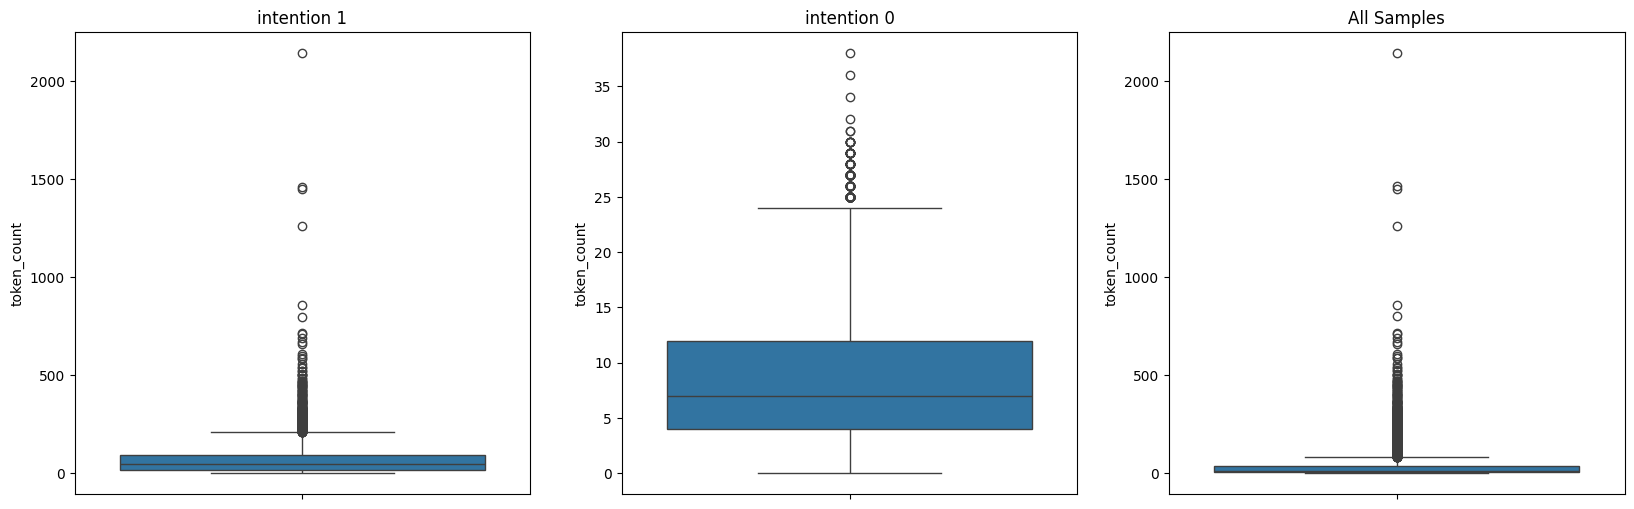

Minimum token count: 0
Maximum token count: 2142
Average token count: 37.3279964908433


In [21]:
labels = data['intention'].unique()
fig, axes = plt.subplots(1, len(labels) + 1, figsize=(20, 6))

for i, label in enumerate(labels):
    sns.boxplot(data[data['intention'] == label]['token_count'], ax=axes[i])
    axes[i].set_title(f'intention {label}')

sns.boxplot(data['token_count'], ax=axes[-1])
axes[-1].set_title('All Samples')

plt.show()

print('Minimum token count:', data['token_count'].min())
print('Maximum token count:', data['token_count'].max())
print('Average token count:', data['token_count'].mean())

# Part One:
# Word2Vec - Word Embedding

First we print available word2vec models

In [22]:
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [23]:
W2V_PATH = '/content/drive/My Drive/word2vec_model.bin'

if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
        print("\nSaving Word2Vec model...")
        w2v_model.save(W2V_PATH)
        print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


In [24]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

In [25]:
EMBEDDING_VECTOR_DIM

300

# Dataset

In [26]:

class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"

        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        vectors = []
        for token in tokens:
            if token in self.w2v_model:
                vectors.append(self.w2v_model[token])
            else:
                vectors.append(np.zeros(self.vector_size))
        return torch.tensor(vectors, dtype=torch.float32)

    def _pad(self, tokens: list):
        if len(tokens) < self.max_sequence_len:
            tokens.extend([''] * (self.max_sequence_len - len(tokens)))
        else:
            tokens = tokens[:self.max_sequence_len]
        return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}]")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}]")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)


In [27]:
data.columns

Index(['tweet', 'intention', 'cleaned_text', 'token_count'], dtype='object')

Now we check it on some samples

In [28]:
data = data.drop(['cleaned_text', 'token_count'], axis="columns")
# Convert data to dataframe if needed
data = pd.DataFrame(data) if not isinstance(data, pd.DataFrame) else data

# Assuming data is already defined and loaded
twitter = Twitter(data, w2v_model, 64)

Deleted 0-Len Samples: 31


<ipython-input-26-6491df8ee47a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-26-6491df8ee47a>:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(vectors, dtype=torch.float32)
<ipython-input-26-6491df8ee47a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [29]:
data.columns

Index(['tweet', 'intention', 'tokens'], dtype='object')

In [30]:
twitter.dataframe.columns

Index(['tweet', 'intention', 'tokens', 'vector'], dtype='object')

In [31]:
twitter.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[15862 ]
:::::All Valid Tokens:::[10641 ]
:::::Valid Tokens:::[67.08%]


## Question 6:
### Explanation of Methods for Handling Out-of-Vocabulary Words

There are some common methods along with their advantages and disadvantages:

1. **Using a Zero Vector**:
    - **Description**: Replace out-of-vocabulary (OOV) words with a zero vector of the same dimension as the word vectors.
    - **Advantages**:
        - Simple to implement.
        - Ensures that the dimension of input vectors remains consistent.
    - **Disadvantages**:
        - Zero vectors do not carry any semantic information.
        - Can negatively impact the performance of models, especially if OOV words are common.

2. **Using a Random Vector**:
    - **Description**: Replace OOV words with a randomly initialized vector of the same dimension as the word vectors.
    - **Advantages**:
        - Provides a unique vector representation for each OOV word.
        - Can help the model learn if the random vectors are initialized appropriately.
    - **Disadvantages**:
        - Random vectors may introduce noise into the model.
        - The randomness can lead to instability in model training.

3. **Using a Special Token Vector (e.g., `<UNK>` token)**:
    - **Description**: Use a predefined special token (like `<UNK>`) for all OOV words and assign it a specific vector.
    - **Advantages**:
        - Keeps the representation consistent and avoids introducing randomness.
        - The model can learn to handle unknown words more effectively.
    - **Disadvantages**:
        - Treats all OOV words the same, which might not be optimal if the OOV words are diverse in meaning.

4. **Subword Tokenization**:
    - **Description**: Break down OOV words into smaller subwords or character n-grams, and use vectors for these subwords.
    - **Advantages**:
        - Can handle morphological variations and unseen words more effectively.
        - Provides more meaningful representations for OOV words by leveraging subword information.
    - **Disadvantages**:
        - More complex to implement compared to other methods.
        - Increases computational complexity due to the need to process subwords.

5. **Using Contextual Embeddings**:
    - **Description**: Use embeddings from models like BERT, which generate contextualized word vectors that can handle OOV words based on their context.
    - **Advantages**:
        - Provides rich, context-dependent representations for all words, including OOV words.
        - Improves the performance of models on tasks involving natural language understanding.
    - **Disadvantages**:
        - Computationally expensive and requires more resources.
        - More complex to integrate and fine-tune compared to static embeddings.

### Conclusion
Each method for handling out-of-vocabulary words has its own strengths and weaknesses. The choice of method depends on the specific requirements of the task and the resources available. For simple tasks with limited computational resources, using a zero vector or a special token might be sufficient. For more complex tasks requiring rich semantic understanding, methods like subword tokenization or contextual embeddings might be more appropriate despite their higher complexity and computational cost.

# Part 2:
Classification using a CNN (Convolutional Neural Network)

## Question 7:
### Adam Optimizer
The Adam (Adaptive Moment Estimation) optimizer combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. It calculates adaptive learning rates for each parameter. The Adam optimizer maintains two moving averages for each parameter:

1. **First moment estimate (mean of gradients):** This is the average of the gradients of the objective function.
2. **Second moment estimate (uncentered variance of gradients):** This is the average of the squared gradients.

These moving averages are updated as follows:
- **First moment (mean):**
  \[
  m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
  \]
- **Second moment (variance):**
  \[
  v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
  \]
- Here, \( \beta_1 \) and \( \beta_2 \) are exponential decay rates (commonly 0.9 and 0.999, respectively), and \( g_t \) is the gradient at time step \( t \).

To correct the bias introduced by the initialization of these moments, bias-corrected estimates are used:
- **Bias-corrected first moment:**
  \[
  \hat{m}_t = \frac{m_t}{1 - \beta_1^t}
  \]
- **Bias-corrected second moment:**
  \[
  \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
  \]

The parameter update rule is:
\[
\theta_t = \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\]
where \( \alpha \) is the learning rate and \( \epsilon \) is a small constant to prevent division by zero (commonly \( 10^{-8} \)).

### SGD Optimizer
Stochastic Gradient Descent (SGD) updates parameters using the gradient of the loss function with respect to the parameters. The update rule for SGD is:
\[
\theta_t = \theta_{t-1} - \alpha g_t
\]
where \( \alpha \) is the learning rate and \( g_t \) is the gradient at time step \( t \).

### Differences between Adam and SGD
1. **Learning Rates:**
   - **SGD:** Uses a fixed or manually adjusted learning rate.
   - **Adam:** Uses adaptive learning rates for each parameter.

2. **Gradient Averaging:**
   - **SGD:** Uses the current gradient to update the parameters.
   - **Adam:** Uses an exponentially decaying average of past gradients (first moment) and an exponentially decaying average of past squared gradients (second moment).

3. **Bias Correction:**
   - **SGD:** No bias correction.
   - **Adam:** Includes bias correction to account for the initialization of the moving averages.

4. **Convergence:**
   - **SGD:** May struggle with noisy gradients and can oscillate.
   - **Adam:** Generally converges faster and handles sparse gradients better due to the adaptive learning rates.

5. **Parameter Sensitivity:**
   - **SGD:** More sensitive to the choice of the learning rate and requires careful tuning.
   - **Adam:** Less sensitive to the initial learning rate, often leading to better results with default settings.

- **Adam** is usually preferred for its faster convergence and better handling of sparse gradients.
- **SGD** can be effective for simpler problems or when training with very large datasets where the noise in gradient estimates is beneficial for escaping local minima.

## Question 8:
In our project, we utilized the Cross Entropy loss function for our classification task, specifically in the context of training a Convolutional Neural Network (CNN). The choice of Cross Entropy loss is well-suited for classification problems like ours, where the goal is to categorize input data into multiple classes.

Cross Entropy loss is particularly effective for classification tasks because it measures the disparity between the predicted probabilities assigned to each class and the true distribution of class labels. By penalizing deviations from the actual labels, Cross Entropy loss guides the model to learn the correct class probabilities during training.

Given that our problem involves classifying input data into distinct categories, the Cross Entropy loss function aligns well with the objective of minimizing classification errors and maximizing the model's ability to accurately predict the correct class for each input sample.

# Prepare Data

In [32]:
twitter.dataframe.columns

Index(['tweet', 'intention', 'tokens', 'vector'], dtype='object')

In [33]:
twitter.dataframe.describe()

,intention
count,9088.000000
mean,0.439921
std,0.496405
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [34]:
twitter.dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9088 entries, 0 to 9087
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9088 non-null   object
 1   intention  9088 non-null   int64 
 2   tokens     9088 non-null   object
 3   vector     9088 non-null   object
dtypes: int64(1), object(3)
memory usage: 284.1+ KB


In [35]:
twitter.dataframe.head(20)

,tweet,intention,tokens,vector
0,my life is meaningless i just want to end my l...,1,"[life, meaningless, want, end, life, badly, li...","[[tensor(-0.0679), tensor(0.0952), tensor(0.03..."
1,muttering i wanna die to myself daily for a fe...,1,"[mutter, wan, na, die, daily, month, feel, wor...","[[tensor(0.0952), tensor(-0.0138), tensor(0.25..."
2,work slave i really feel like my only purpose ...,1,"[work, slave, really, feel, like, purpose, lif...","[[tensor(-0.0757), tensor(0.0337), tensor(-0.0..."
3,i did something on the 2 of october i overdose...,1,"[something, october, overdose, felt, alone, ho...","[[tensor(0.1123), tensor(0.0183), tensor(0.077..."
4,i feel like no one cares i just want to die ma...,1,"[feel, like, one, care, want, die, maybe, feel...","[[tensor(-0.0557), tensor(0.0137), tensor(-0.1..."
5,i am great and wonderful i am worth it except ...,1,"[great, wonderful, worth, except, enough, anyo...","[[tensor(0.0718), tensor(0.2080), tensor(-0.02..."
6,i ll be dead just you wait and see my last wor...,1,"[dead, wait, see, last, word, death, whoever, ...","[[tensor(0.1494), tensor(0.1650), tensor(0.273..."
7,health anxiety prompting some bad thoughts in ...,1,"[health, anxiety, prompt, bad, thought, head, ...","[[tensor(-0.0742), tensor(0.1128), tensor(0.09..."
8,everything is okay but nothing feels okay i ve...,1,"[everything, okay, nothing, feel, okay, always...","[[tensor(0.1123), tensor(-0.0371), tensor(-0.1..."
9,ptsd and alcohol i had some extremely horrible...,1,"[ptsd, alcohol, extremely, horrible, violent, ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."


## Split Data into train-valid

In [36]:
from sklearn.model_selection import train_test_split


# Splitting the dataset into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

## Create Datasets

In [37]:
# TODO: create twitter dataset
train_dataset = Twitter(train_data, w2v_model, 64)
valid_dataset = Twitter(test_data, w2v_model, 64)


Deleted 0-Len Samples: 23


<ipython-input-26-6491df8ee47a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-26-6491df8ee47a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


Deleted 0-Len Samples: 8


<ipython-input-26-6491df8ee47a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-26-6491df8ee47a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [38]:
print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Train dataset length: 7272
Valid dataset length: 1816


## Question 9:
In CNN models, and generally in machine learning, the dataset is often split into training and testing sets to evaluate the model's performance on unseen data. The common practice of splitting data in an 80-20 range (80% training, 20% testing) is motivated by several reasons:

1. **Sufficient Training Data**: A model needs a substantial amount of data to learn patterns effectively. Allocating 80% of the data to training ensures that the model has enough examples to learn from, which helps improve its generalization ability.

2. **Reliable Evaluation**: The remaining 20% is used for testing to evaluate the model's performance on unseen data. This helps in assessing how well the model generalizes to new, unseen examples. A 20% test set is generally large enough to provide a reliable estimate of the model's performance.

3. **Balance**: The 80-20 split strikes a balance between having enough data for training and enough for testing. If the training set is too small, the model might not learn adequately. Conversely, if the test set is too small, the evaluation might not be reliable.

4. **Standard Practice**: The 80-20 split is a widely accepted convention in the machine learning community. This convention makes it easier to compare results across different studies and experiments, as it provides a common baseline.

5. **Avoiding Overfitting**: By evaluating the model on a separate test set, we can detect if the model is overfitting the training data. Overfitting occurs when a model learns the training data too well, including its noise and outliers, which negatively impacts its performance on new data.

6. **Computational Efficiency**: In practical scenarios, especially with large datasets, the 80-20 split ensures that the model training and evaluation are computationally efficient. Training on 80% of the data usually provides a good balance between performance and training time.

The 80-20 split is a pragmatic choice that ensures the model has enough data to learn from while reserving a sufficient portion for reliable performance evaluation. This balance helps in developing robust models that generalize well to new, unseen data.

# Model and Train

## Utils

In [70]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: str = 'auto'):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0
    correct_predictions = 0
    total_predictions = 0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    #model.eval()  # Set the model to evaluation mode
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # TODO: move model's inputs to `device`
        inputs, labels = inputs.to(device), labels.to(device)

        # TODO: use model's forward pass to generate outputs
        outputs = model(inputs)

        # TODO: calculate model's loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # TODO: calculate/update model's accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        test_acc = correct_predictions / total_predictions

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )
    test_loss /= len(loader)
    return test_loss, test_acc


In [71]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: str ='auto',
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # TODO: create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    # model.to(device)

    # itr = tqdm(train_loader, total=len(train_loader), leave=False)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        correct_predictions = 0
        total_predictions = 0

        itr = tqdm(train_loader, total=len(train_loader), leave=True, desc=f"(Training) Epoch [{epoch + 1}/{epochs}]")

        for idx, (inputs, labels) in enumerate(itr, start=1):
            # TODO: move model's inputs to `device`
            inputs, labels = inputs.to(device), labels.to(device)

            # TODO: use model's forward pass to generate outputs
            outputs = model(inputs)

            # TODO: process model's predictipns and calculate/update accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            epoch_acc = correct_predictions / total_predictions

            # TODO: calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            # TODO: 1. clear optimizer's state and zero prev grads,
            optimizer.zero_grad()
            # TODO: 2. backward calculated loss
            loss.backward()
            # TODO: 3. step optimizer
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=round(epoch_acc, 5),
              )

        epoch_loss /= len(itr)
        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )


        # TODO: update statistics regaurding model's loss and acc in training or validation phases
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        print(f"Epoch [{epoch + 1}/{epochs}]")
        print(f"Train Loss: {epoch_loss:.5f}, Train Accuracy: {epoch_acc:.5f}")
        print(f"Validation Loss: {valid_loss:.5f}, Validation Accuracy: {valid_acc:.5f}")


    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [72]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [73]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    # TODO: code here, you must fill variables below
    # TODO: labels = true labels from the dataset
    # TODO: predicted = labels predicted by the model
    all_labels = []
    all_predictions = []

    for inputs, labels in itr:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    labels = all_labels
    predicted = all_predictions

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [74]:
class CNN(nn.Module):
    def __init__(self, context=64, regularization=False, dropout=0.5): # TODO: define your args here
        super(CNN, self).__init__()

        self.regularization = regularization

        # First block of Conv1D layers
        self.conv1_3 = nn.Conv1d(in_channels=context, out_channels=64, kernel_size=3, padding=1)
        self.conv1_5 = nn.Conv1d(in_channels=context, out_channels=64, kernel_size=5, padding=2)
        self.conv1_7 = nn.Conv1d(in_channels=context, out_channels=64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()

        # Second block of Conv1D layers
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv2_7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)

        self.max_pool = nn.MaxPool1d(kernel_size=2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected (linear) layers
        self.fc1 = nn.Linear(in_features=128 * 3, out_features=128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):

        # First block of Conv1D layers
        x1 = self.relu(self.conv1_3(x))
        x2 = self.relu(self.conv1_5(x))
        x3 = self.relu(self.conv1_7(x))

        # Concatenate outputs of first block along the channel dimension
        #x = torch.cat((x1, x2, x3), dim=1)

        # Second block of Conv1D layers
        if (self.regularization):
          x1_2 = self.relu(self.bn2(self.conv2_3(x1)))
          x2_2 = self.relu(self.bn2(self.conv2_5(x2)))
          x3_2 = self.relu(self.bn2(self.conv2_7(x3)))
        else:
          x1_2 = self.relu(self.conv2_3(x1))
          x2_2 = self.relu(self.conv2_5(x2))
          x3_2 = self.relu(self.conv2_7(x3))



        x1_2 = self.max_pool(x1_2)
        x2_2 = self.max_pool(x2_2)
        x3_2 = self.max_pool(x3_2)


        x1_2 = self.global_avg_pool(x1_2)
        x2_2 = self.global_avg_pool(x2_2)
        x3_2 = self.global_avg_pool(x3_2)

        # Concatenate outputs of second block along the channel dimension
        x = torch.cat((x1_2, x2_2, x3_2), dim=1)

        # Flatten the tensor
        x = self.flatten(x)
        x = self.fc1(x)

        # Fully connected (linear) layers
        if (self.regularization):
          x = self.dropout(x)
        x = self.fc2(x)

        # return
        return x

## Training

In [75]:
# TODO: instantiate your model here
model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 32
epochs = 10

In [45]:
cnn_model_train_history = train_model(
    model=model,  # Pass your instantiated CNN model
    batch_size=batch_size,  # Set your desired batch size
    loss_function=loss_function,  # Use Cross Entropy loss function
    optimizer=optimizer,  # Use Adam optimizer
    epochs=epochs,  # Set the number of epochs for training
    train_set=train_dataset,  # Pass your training dataset
    valid_set=valid_dataset,  # Pass your validation dataset
    device="auto",  # Specify device for training
)

(Training) Epoch [1/10]: 100%|██████████| 228/228 [01:10<00:00,  3.23it/s, accuracy=0.829, loss=0.294]


Epoch [1/10]
Train Loss: 87.74129, Train Accuracy: 0.82948
Validation Loss: 645.94643, Validation Accuracy: 0.84416


(Training) Epoch [2/10]: 100%|██████████| 228/228 [01:09<00:00,  3.28it/s, accuracy=0.846, loss=0.622]


Epoch [2/10]
Train Loss: 80.25717, Train Accuracy: 0.84557
Validation Loss: 625.86775, Validation Accuracy: 0.85297


(Training) Epoch [3/10]: 100%|██████████| 228/228 [01:08<00:00,  3.35it/s, accuracy=0.849, loss=0.117]


Epoch [3/10]
Train Loss: 78.71908, Train Accuracy: 0.84915
Validation Loss: 606.75253, Validation Accuracy: 0.85848


(Training) Epoch [4/10]: 100%|██████████| 228/228 [01:07<00:00,  3.38it/s, accuracy=0.853, loss=0.24]


Epoch [4/10]
Train Loss: 76.55144, Train Accuracy: 0.85341
Validation Loss: 610.48058, Validation Accuracy: 0.85738


(Training) Epoch [5/10]: 100%|██████████| 228/228 [01:07<00:00,  3.37it/s, accuracy=0.856, loss=0.172]


Epoch [5/10]
Train Loss: 76.03297, Train Accuracy: 0.85644
Validation Loss: 612.82772, Validation Accuracy: 0.85683


(Training) Epoch [6/10]: 100%|██████████| 228/228 [01:10<00:00,  3.22it/s, accuracy=0.86, loss=0.0409]


Epoch [6/10]
Train Loss: 73.71200, Train Accuracy: 0.86001
Validation Loss: 615.79235, Validation Accuracy: 0.85738


(Training) Epoch [7/10]: 100%|██████████| 228/228 [01:09<00:00,  3.29it/s, accuracy=0.861, loss=0.173]


Epoch [7/10]
Train Loss: 73.29245, Train Accuracy: 0.86125
Validation Loss: 599.21322, Validation Accuracy: 0.85022


(Training) Epoch [8/10]: 100%|██████████| 228/228 [01:09<00:00,  3.26it/s, accuracy=0.869, loss=0.471]


Epoch [8/10]
Train Loss: 71.64468, Train Accuracy: 0.86936
Validation Loss: 607.43841, Validation Accuracy: 0.85352


(Training) Epoch [9/10]: 100%|██████████| 228/228 [01:07<00:00,  3.37it/s, accuracy=0.873, loss=0.205]


Epoch [9/10]
Train Loss: 68.79722, Train Accuracy: 0.87321
Validation Loss: 726.95064, Validation Accuracy: 0.84967


(Training) Epoch [10/10]: 100%|██████████| 228/228 [01:07<00:00,  3.37it/s, accuracy=0.874, loss=0.156]
                                                                                   

Epoch [10/10]
Train Loss: 69.44144, Train Accuracy: 0.87431
Validation Loss: 587.84949, Validation Accuracy: 0.85407


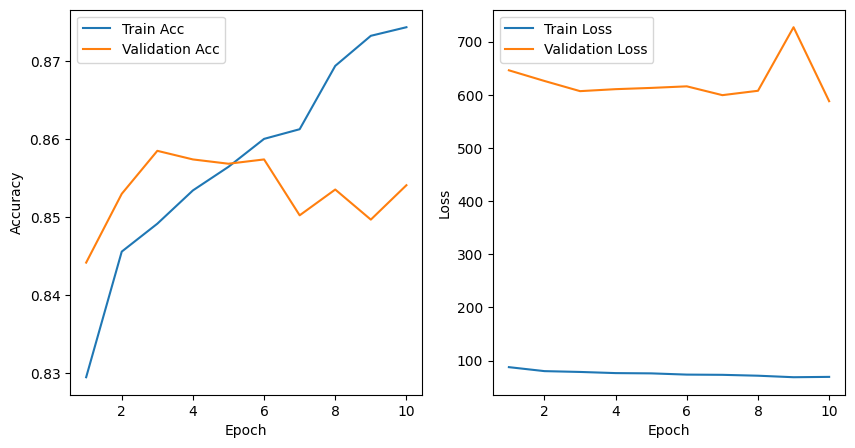

In [46]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

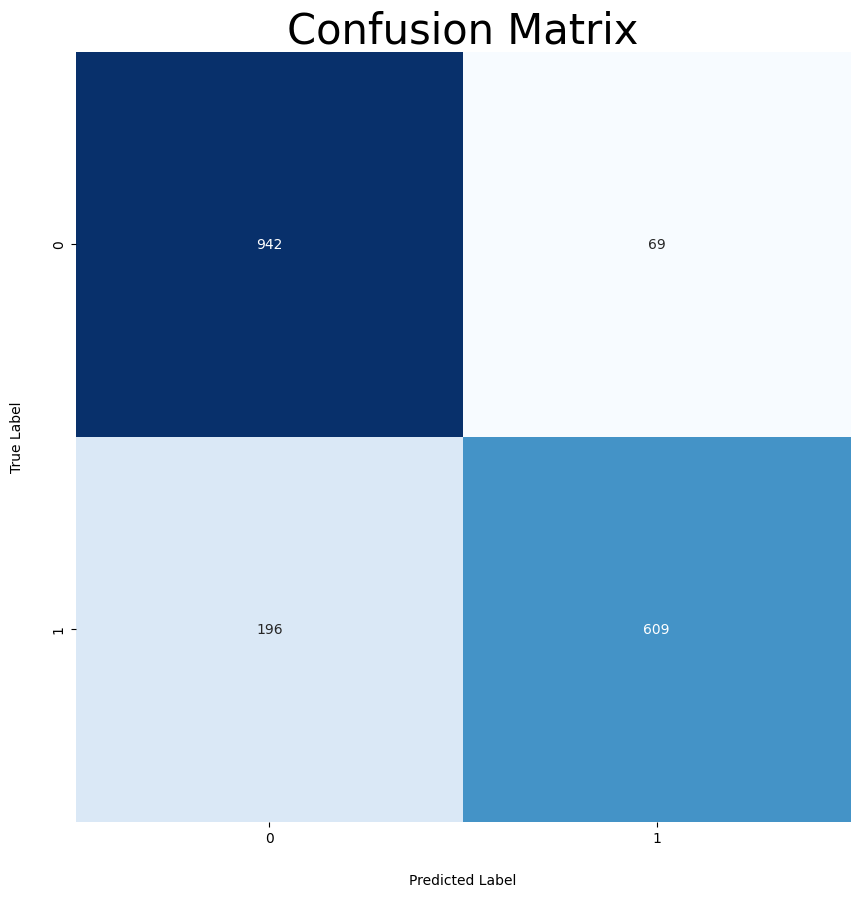

In [47]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [49]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.844
F1:        0.849
Precision: 0.863
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1011
           1       0.90      0.76      0.82       805

    accuracy                           0.85      1816
   macro avg       0.86      0.84      0.85      1816
weighted avg       0.86      0.85      0.85      1816



## Question 10:
The kernel size in convolutional layers significantly impacts feature extraction in Convolutional Neural Networks (CNNs). A smaller kernel size focuses on fine details and local features, capturing subtle patterns and textures. In contrast, a larger kernel size covers a broader area of the input, capturing more global and abstract features. Using smaller kernels can lead to more detailed and localized feature maps, while larger kernels provide a more holistic view of the input data. The choice of kernel size depends on the specific requirements of the task and the nature of the data being processed.

## Question 11:
In our project, we chose not to reduce the output of the convolutional layers directly, opting instead to perform the reduction through the feed-forward layers. This decision was based on considerations regarding the preservation of spatial information and the need for high-level feature abstraction.

**Reasoning Behind Not Reducing the Output of Convolution:**
We decided against reducing the output of the convolutional layers to preserve spatial information and capture detailed features from the input data. In tasks such as text classification, where spatial relationships are important, maintaining the output size of the convolutional layers can aid in extracting meaningful patterns.

**Performing Reduction Through Feed-Forward Layers:**
Reduction was carried out through the feed-forward layers to facilitate feature aggregation and abstraction. By applying reduction in the feed-forward layers, the model can learn higher-level representations of the features extracted by the convolutional layers. This approach allows for non-linear transformations and enables the model to capture complex patterns and relationships within the data.

**Advantages of Using Feed-Forward Layers for Reduction:**
Using feed-forward layers for reduction offers several advantages over alternative methods. Firstly, it provides flexibility in network architecture design, allowing for the incorporation of various layers such as dropout and batch normalization. Secondly, parameter sharing across the entire input space is facilitated, promoting the learning of robust and discriminative features. Lastly, separating the reduction process from the convolutional layers allows for adaptive adjustment of feature abstraction levels based on task requirements.

**Outcome:**
In our project, employing feed-forward layers for reduction yielded promising results. We observed improvements in model performance, particularly in terms of training convergence and generalization ability. However, we also encountered challenges related to model complexity and training time, indicating potential areas for further optimization.

**Conclusion:**
In conclusion, our decision to perform reduction through feed-forward layers was guided by the need to balance spatial information preservation and feature abstraction. By leveraging the advantages of feed-forward layers, we were able to enhance our model's ability to extract meaningful patterns from the input data. Thoughtful design choices in neural network architectures are crucial for achieving optimal performance in real-world tasks.

In [116]:
# Define lists of batch sizes and learning rates to experiment with
# batch_sizes = [32, 64, 128]
# learning_rates = [0.001, 0.01, 0.1]


# # Iterate over batch sizes and learning rates
# for batch_size in batch_sizes:
#     for learning_rate in learning_rates:
#         print(f"Training with batch size: {batch_size}, learning rate: {learning_rate}")

#         # Train the model with the current batch size and learning rate
#         cnn_model_train_history = train_model(
#             model=model,
#             batch_size=batch_size,
#             loss_function=loss_function,
#             optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate),  # Pass the learning rate to the optimizer
#             epochs=epochs,
#             train_set=train_dataset,
#             valid_set=valid_dataset,
#             device="auto"
#         )

#         # Report the effects of the training
#         print("Training completed. Report the effects here...")


# Part 3:

## Question 12:
Increasing the size of the text window to encompass more sentences in a convolutional neural network (CNN) can offer both advantages and disadvantages:

**Advantages**:
1. **Contextual Understanding**: A larger text window allows the model to capture more contextual information from the surrounding sentences. This can lead to a better understanding of the overall context of the text and may improve the model's performance in tasks such as text classification or sentiment analysis.
  
2. **Enhanced Feature Extraction**: With a larger text window, the CNN can potentially extract more diverse and informative features from the input text. This may result in richer representations of the text data, leading to improved discriminative power and generalization ability of the model.
  
3. **Robustness to Variability**: By considering a broader context, the model becomes more robust to variations in sentence structures and lengths. This can help mitigate issues related to sentence boundaries and improve the model's ability to handle texts of varying lengths.

**Disadvantages**:
1. **Increased Computational Complexity**: Enlarging the text window results in an increase in the number of input tokens processed by the CNN. This leads to higher computational costs during both training and inference, potentially requiring more memory and processing resources.
  
2. **Potential Information Overload**: A larger text window may introduce noise or irrelevant information, especially if the text contains a mixture of different topics or themes. This could dilute the relevant features and make it harder for the model to discern important patterns from the input.
  
3. **Risk of Overfitting**: With a larger receptive field, there's a risk of overfitting to the training data, particularly if the model becomes too sensitive to specific combinations of words or phrases present in the extended text window. Regularization techniques may be necessary to mitigate this risk.

While increasing the size of the text window in a CNN can provide benefits in terms of contextual understanding and feature extraction, it also comes with challenges related to computational complexity, information overload, and the risk of overfitting. Careful consideration of these factors is essential when deciding on the appropriate text window size for a given task.

## Question 13:

In [54]:
train_dataset2 = Twitter(train_data, w2v_model, 196)
valid_dataset2 = Twitter(test_data, w2v_model, 196)

Deleted 0-Len Samples: 23


<ipython-input-26-6491df8ee47a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-26-6491df8ee47a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


Deleted 0-Len Samples: 8


<ipython-input-26-6491df8ee47a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-26-6491df8ee47a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [78]:
model2 = CNN(context=196)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
batch_size = 32
epochs = 10

In [79]:
cnn_model_train_history2 = train_model(
    model=model2,  # Pass your instantiated CNN model
    batch_size=batch_size,  # Set your desired batch size
    loss_function=loss_function,  # Use Cross Entropy loss function
    optimizer=optimizer,  # Use Adam optimizer
    epochs=epochs,  # Set the number of epochs for training
    train_set=train_dataset2,  # Pass your training dataset
    valid_set=valid_dataset2,  # Pass your validation dataset
    device="auto",  # Specify device for training
)

(Training) Epoch [1/10]: 100%|██████████| 228/228 [01:33<00:00,  2.44it/s, accuracy=0.829, loss=0.31]


Epoch [1/10]
Train Loss: 0.37850, Train Accuracy: 0.82907
Validation Loss: 0.34000, Validation Accuracy: 0.85132


(Training) Epoch [2/10]: 100%|██████████| 228/228 [01:33<00:00,  2.43it/s, accuracy=0.844, loss=0.597]


Epoch [2/10]
Train Loss: 0.35309, Train Accuracy: 0.84351
Validation Loss: 0.33645, Validation Accuracy: 0.85187


(Training) Epoch [3/10]: 100%|██████████| 228/228 [01:33<00:00,  2.43it/s, accuracy=0.854, loss=0.31]


Epoch [3/10]
Train Loss: 0.34238, Train Accuracy: 0.85396
Validation Loss: 0.36926, Validation Accuracy: 0.84361


(Training) Epoch [4/10]: 100%|██████████| 228/228 [01:32<00:00,  2.46it/s, accuracy=0.854, loss=0.525]


Epoch [4/10]
Train Loss: 0.33968, Train Accuracy: 0.85424
Validation Loss: 0.33341, Validation Accuracy: 0.85022


(Training) Epoch [5/10]: 100%|██████████| 228/228 [01:32<00:00,  2.46it/s, accuracy=0.856, loss=0.147]


Epoch [5/10]
Train Loss: 0.33251, Train Accuracy: 0.85589
Validation Loss: 0.33292, Validation Accuracy: 0.85738


(Training) Epoch [6/10]: 100%|██████████| 228/228 [01:32<00:00,  2.46it/s, accuracy=0.856, loss=0.245]


Epoch [6/10]
Train Loss: 0.33670, Train Accuracy: 0.85561
Validation Loss: 0.35507, Validation Accuracy: 0.84526


(Training) Epoch [7/10]: 100%|██████████| 228/228 [01:32<00:00,  2.47it/s, accuracy=0.861, loss=0.281]


Epoch [7/10]
Train Loss: 0.32439, Train Accuracy: 0.86070
Validation Loss: 0.32899, Validation Accuracy: 0.85683


(Training) Epoch [8/10]: 100%|██████████| 228/228 [01:32<00:00,  2.46it/s, accuracy=0.868, loss=0.219]


Epoch [8/10]
Train Loss: 0.31633, Train Accuracy: 0.86826
Validation Loss: 0.34583, Validation Accuracy: 0.85242


(Training) Epoch [9/10]: 100%|██████████| 228/228 [01:33<00:00,  2.43it/s, accuracy=0.87, loss=0.77]


Epoch [9/10]
Train Loss: 0.31508, Train Accuracy: 0.87032
Validation Loss: 0.38108, Validation Accuracy: 0.85022


(Training) Epoch [10/10]: 100%|██████████| 228/228 [01:33<00:00,  2.43it/s, accuracy=0.871, loss=0.287]
                                                                                   

Epoch [10/10]
Train Loss: 0.30879, Train Accuracy: 0.87129
Validation Loss: 0.33264, Validation Accuracy: 0.85628


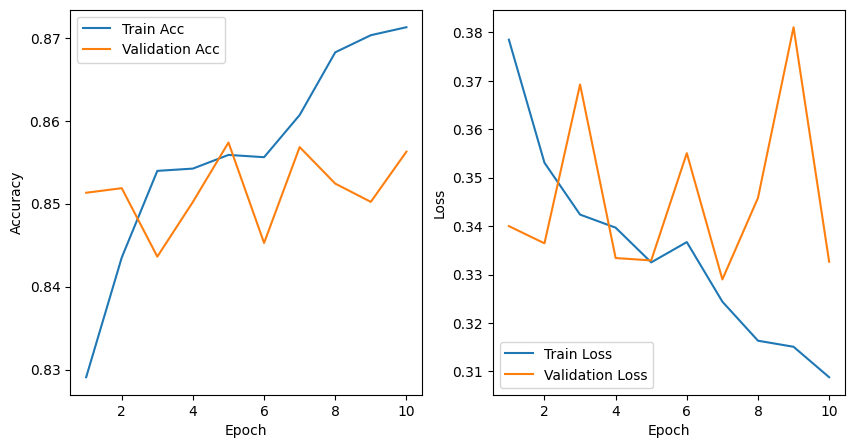

In [109]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history2["train_acc"]),
            ("Validation Acc", cnn_model_train_history2["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history2["train_loss"]),
            ("Validation Loss", cnn_model_train_history2["valid_loss"])
        ]
    }
)

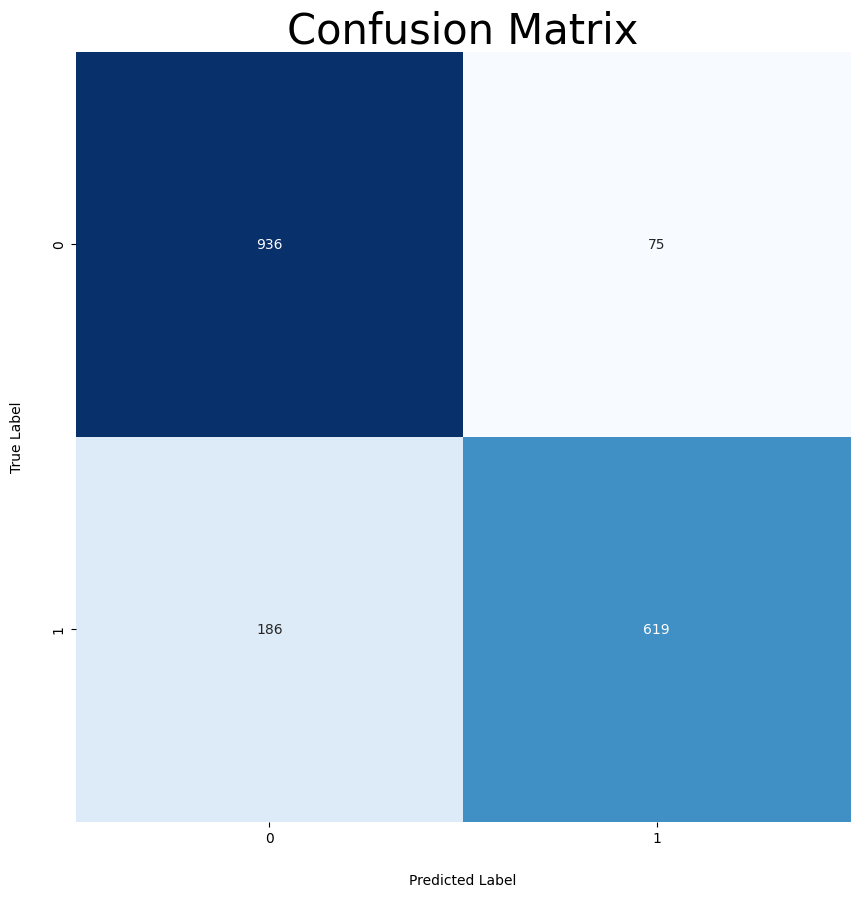

In [84]:
cnn_model_report2 = generate_confusion_matrix(
    model=model2,
    dataset=valid_dataset2,
)

In [85]:
print(f"Recall:    {cnn_model_report2['recall']:.3f}")
print(f"F1:        {cnn_model_report2['f1']:.3f}")
print(f"Precision: {cnn_model_report2['precision']:.3f}")
print(cnn_model_report2['report'])

Recall:    0.847
F1:        0.852
Precision: 0.863
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1011
           1       0.89      0.77      0.83       805

    accuracy                           0.86      1816
   macro avg       0.86      0.85      0.85      1816
weighted avg       0.86      0.86      0.85      1816



In convolutional neural network (CNN) models, increasing the context can indeed lead to improved performance in certain cases. Here's why:

1. **Capturing Longer-Term Dependencies**: CNNs are effective at capturing local patterns in data due to their local receptive fields. By increasing the context, the model can capture longer-term dependencies and relationships between distant elements in the input data. This is particularly beneficial for tasks where understanding broader context is essential, such as document classification or sentiment analysis.

2. **Enhanced Feature Extraction**: With a larger context, the CNN can extract more diverse and informative features from the input data. This can lead to richer representations of the data, potentially improving the model's ability to discriminate between different classes or categories.

3. **Improved Generalization**: By incorporating more context into the model, it becomes more robust to variations and noise in the input data. This can improve the model's generalization ability, enabling it to perform well on unseen examples or in different contexts.

However, it's essential to consider potential challenges when increasing the context in CNN models:

1. **Increased Computational Complexity**: Larger context sizes result in more parameters and computations, leading to increased computational costs during training and inference. This can pose challenges, especially in resource-constrained environments or when dealing with large datasets.

2. **Risk of Overfitting**: Increasing the context may introduce more complexity into the model, increasing the risk of overfitting to the training data. Regularization techniques, such as dropout or weight decay, may be necessary to mitigate this risk.

3. **Optimal Context Size**: Determining the optimal context size can be challenging and may require experimentation. A context size that is too small may limit the model's ability to capture long-range dependencies, while a context size that is too large may introduce noise or irrelevant information into the model.

While increasing the context in CNN models can lead to improved performance by capturing longer-term dependencies and enhancing feature extraction, it's essential to carefully consider computational costs, risk of overfitting, and the optimal context size for the task at hand.

# Part 4:

<a name='6'></a>
## <a id='toc7_'></a>Regularization [](#toc0_)

* **Batch Norm**
> **The need for Batch Norm**:<br>
Consider any of the hidden layers of a network. The activations from the previous layer are simply the inputs to this layer. For instance, from the perspective of Layer 2 in the picture below, if we “blank out” all the previous layers, the activations coming from Layer 1 are no different from the original inputs.<br>
The same logic that requires us to normalize the input for the first layer will also apply to each of these hidden layers.

    > **How Does Batch Norm work**?<br>
Batch Norm is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.
Just like the parameters (eg. weights, bias) of any network layer, a Batch Norm layer also has parameters of its own.

* **Dropout**

    The dropout layer functions by randomly deactivating a portion of input units during each training update. This implies that during forward propagation, certain neurons in the network are ‘dropped out’ or temporarily disregard, along with their associated connections, based on a specific probability.

In [111]:
model3 = CNN(context=64, regularization=True, dropout=0.5)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)
batch_size = 128
epochs = 15

In [112]:
nn_model_train_history3 = train_model(
    model=model3,  # Pass your instantiated CNN model
    batch_size=batch_size,  # Set your desired batch size
    loss_function=loss_function,  # Use Cross Entropy loss function
    optimizer=optimizer,  # Use Adam optimizer
    epochs=epochs,  # Set the number of epochs for training
    train_set=train_dataset,  # Pass your training dataset
    valid_set=valid_dataset,  # Pass your validation dataset
    device="auto",  # Specify device for training
)

(Training) Epoch [1/15]: 100%|██████████| 57/57 [01:09<00:00,  1.22s/it, accuracy=0.819, loss=0.409]


Epoch [1/15]
Train Loss: 0.39794, Train Accuracy: 0.81931
Validation Loss: 1.73033, Validation Accuracy: 0.44328


(Training) Epoch [2/15]: 100%|██████████| 57/57 [01:09<00:00,  1.22s/it, accuracy=0.84, loss=0.316]


Epoch [2/15]
Train Loss: 0.36147, Train Accuracy: 0.83993
Validation Loss: 1.69735, Validation Accuracy: 0.44328


(Training) Epoch [3/15]: 100%|██████████| 57/57 [01:09<00:00,  1.22s/it, accuracy=0.844, loss=0.386]


Epoch [3/15]
Train Loss: 0.35889, Train Accuracy: 0.84447
Validation Loss: 1.46881, Validation Accuracy: 0.44328


(Training) Epoch [4/15]: 100%|██████████| 57/57 [01:08<00:00,  1.21s/it, accuracy=0.85, loss=0.346]


Epoch [4/15]
Train Loss: 0.34919, Train Accuracy: 0.84970
Validation Loss: 1.84910, Validation Accuracy: 0.44328


(Training) Epoch [5/15]: 100%|██████████| 57/57 [01:07<00:00,  1.19s/it, accuracy=0.85, loss=0.327]


Epoch [5/15]
Train Loss: 0.34852, Train Accuracy: 0.84997
Validation Loss: 1.15131, Validation Accuracy: 0.44328


(Training) Epoch [6/15]: 100%|██████████| 57/57 [01:07<00:00,  1.18s/it, accuracy=0.858, loss=0.389]


Epoch [6/15]
Train Loss: 0.33032, Train Accuracy: 0.85822
Validation Loss: 1.12609, Validation Accuracy: 0.44328


(Training) Epoch [7/15]: 100%|██████████| 57/57 [01:07<00:00,  1.18s/it, accuracy=0.864, loss=0.328]


Epoch [7/15]
Train Loss: 0.32208, Train Accuracy: 0.86400
Validation Loss: 1.10317, Validation Accuracy: 0.44769


(Training) Epoch [8/15]: 100%|██████████| 57/57 [01:07<00:00,  1.18s/it, accuracy=0.864, loss=0.239]


Epoch [8/15]
Train Loss: 0.32315, Train Accuracy: 0.86441
Validation Loss: 0.49842, Validation Accuracy: 0.75771


(Training) Epoch [9/15]: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it, accuracy=0.875, loss=0.235]


Epoch [9/15]
Train Loss: 0.29823, Train Accuracy: 0.87528
Validation Loss: 0.66489, Validation Accuracy: 0.54736


(Training) Epoch [10/15]: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it, accuracy=0.877, loss=0.222]


Epoch [10/15]
Train Loss: 0.29336, Train Accuracy: 0.87665
Validation Loss: 0.37889, Validation Accuracy: 0.85683


(Training) Epoch [11/15]: 100%|██████████| 57/57 [01:09<00:00,  1.22s/it, accuracy=0.892, loss=0.259]


Epoch [11/15]
Train Loss: 0.27618, Train Accuracy: 0.89178
Validation Loss: 0.39699, Validation Accuracy: 0.84912


(Training) Epoch [12/15]: 100%|██████████| 57/57 [01:09<00:00,  1.22s/it, accuracy=0.894, loss=0.141]


Epoch [12/15]
Train Loss: 0.26511, Train Accuracy: 0.89398
Validation Loss: 0.41494, Validation Accuracy: 0.82104


(Training) Epoch [13/15]: 100%|██████████| 57/57 [01:09<00:00,  1.21s/it, accuracy=0.895, loss=0.225]


Epoch [13/15]
Train Loss: 0.26570, Train Accuracy: 0.89549
Validation Loss: 0.51372, Validation Accuracy: 0.84912


(Training) Epoch [14/15]: 100%|██████████| 57/57 [01:09<00:00,  1.22s/it, accuracy=0.909, loss=0.233]


Epoch [14/15]
Train Loss: 0.23542, Train Accuracy: 0.90897
Validation Loss: 0.62174, Validation Accuracy: 0.82269


(Training) Epoch [15/15]: 100%|██████████| 57/57 [01:09<00:00,  1.22s/it, accuracy=0.915, loss=0.223]
                                                                                  

Epoch [15/15]
Train Loss: 0.21986, Train Accuracy: 0.91488
Validation Loss: 1.43245, Validation Accuracy: 0.80396


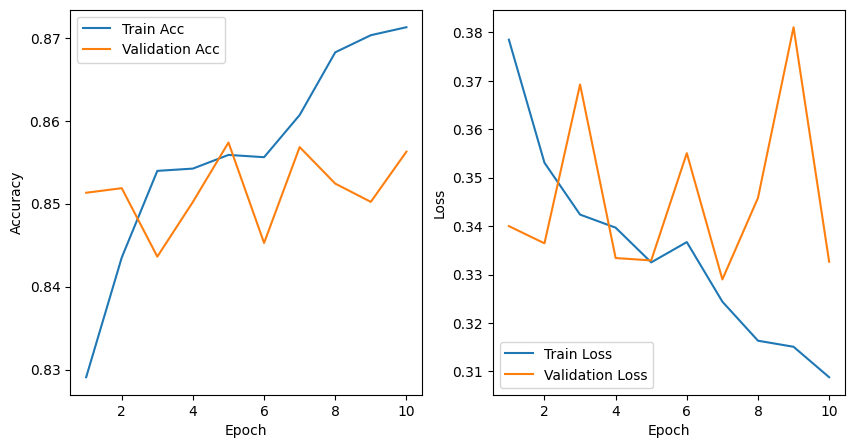

In [113]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history2["train_acc"]),
            ("Validation Acc", cnn_model_train_history2["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history2["train_loss"]),
            ("Validation Loss", cnn_model_train_history2["valid_loss"])
        ]
    }
)

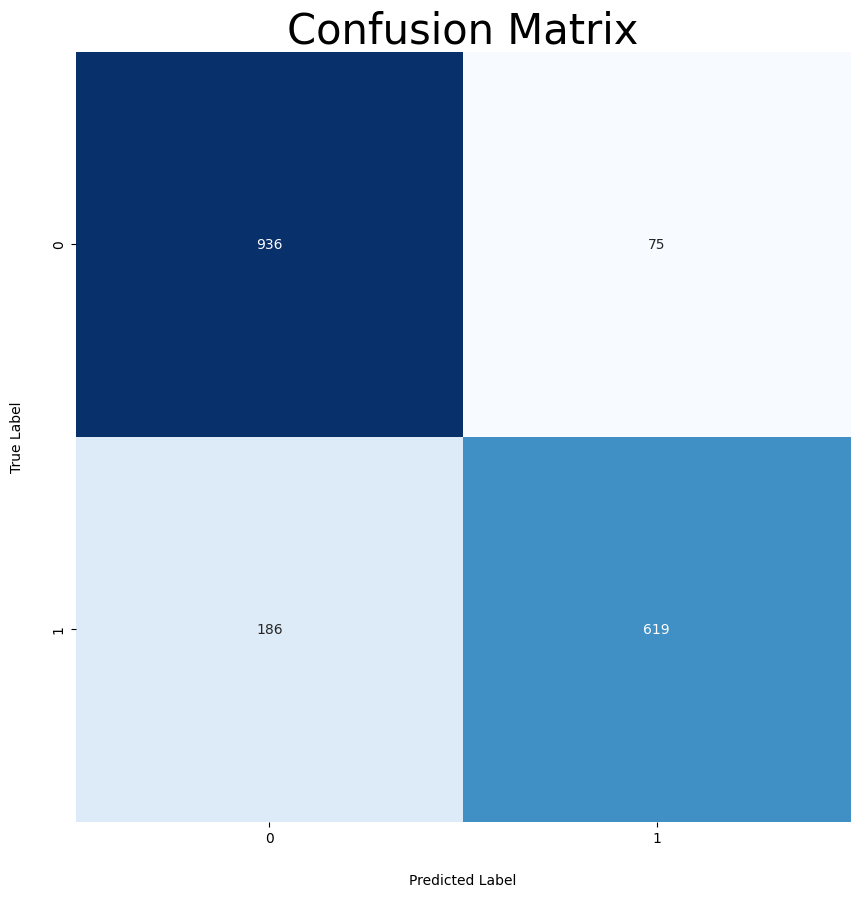

In [114]:
cnn_model_report2 = generate_confusion_matrix(
    model=model2,
    dataset=valid_dataset2,
)

In [115]:
print(f"Recall:    {cnn_model_report2['recall']:.3f}")
print(f"F1:        {cnn_model_report2['f1']:.3f}")
print(f"Precision: {cnn_model_report2['precision']:.3f}")
print(cnn_model_report2['report'])

Recall:    0.847
F1:        0.852
Precision: 0.863
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1011
           1       0.89      0.77      0.83       805

    accuracy                           0.86      1816
   macro avg       0.86      0.85      0.85      1816
weighted avg       0.86      0.86      0.85      1816



As you can see, the model achieves higher accuracy without regularization. The reason behind this is that we employ oversampling, and some of the data is present in both the training and testing sets. Consequently, when the model overfits during the initial phase, it attains a good accuracy in the test set as well. However, in reality, when we present it with completely unseen data, the model with regularization performs better.